# Lab: Node Classification with Graph Neural Networks (GNNs)

In this lab, we will explore how to use Graph Neural Networks (GNNs), specifically Graph Convolutional Networks (GCNs), for node classification tasks on graph data. We will work with the Cora citation dataset, implement a GCN model, train it, and evaluate its performance.

---

## Table of Contents

1. [Introduction to Graph Neural Networks](#1-introduction-to-graph-neural-networks)
2. [Setting Up the Environment](#2-setting-up-the-environment)
3. [Loading and Exploring the Cora Dataset](#3-loading-and-exploring-the-cora-dataset)
4. [Understanding Graph Convolutional Networks (GCNs)](#4-understanding-graph-convolutional-networks-gcns)
5. [Implementing the GCN Model](#5-implementing-the-gcn-model)
6. [Training and Evaluating the Model](#6-training-and-evaluating-the-model)
7. [Visualizing Training Results](#7-visualizing-training-results)


---

## 1. Introduction to Graph Neural Networks

Graph Neural Networks (GNNs) are a class of neural networks designed to handle graph-structured data. Unlike traditional neural networks, which operate on fixed-size vectors or sequences, GNNs can process data where relationships are defined by edges between nodes.

### Applications of GNNs:

- **Node Classification:** Predicting the label of each node in a graph.
- **Link Prediction:** Predicting the existence of edges between nodes.
- **Graph Classification:** Classifying entire graphs.

In this lab, we will focus on **node classification** using a GCN.

---

## 2. Setting Up the Environment

We will use PyTorch Geometric, a library built upon PyTorch to handle graph data and GNNs.

**Code: Install PyTorch Geometric**

In [1]:
try:
    # Check if PyTorch Geometric is installed
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it
    # Adjust the URLs according to your PyTorch version and CUDA availability
    import os
    if 'google.colab' in str(get_ipython()):
        # Install for Google Colab environment
        !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
        !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
        !pip install torch-geometric
    else:
        %pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
        %pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
        %pip install torch-geometric

Note: If you are running on Google Colab or a different version of PyTorch, you may need to adjust the installation commands according to your environment.

## 3. Loading and Exploring the Cora Dataset

The Cora dataset is a citation network where nodes represent publications and edges represent citations between them. Each node is described by a word vector indicating the presence of words from a dictionary, and each node belongs to one of seven classes.

### 3.1 Loading the Dataset

Code: Load the Cora Dataset

In [2]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Load the dataset with normalized features
dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())

# Get the data object
data = dataset[0]

### 3.2 Exploring the Dataset

Let’s explore some basic information about the dataset.

Code: Dataset Statistics

In [3]:
print(f"Dataset Name: {dataset.name}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")

print("\nData Attributes:")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges // 2}")  # Divided by 2 for undirected edges
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Training nodes: {data.train_mask.sum()}")
print(f"Validation nodes: {data.val_mask.sum()}")
print(f"Test nodes: {data.test_mask.sum()}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Is directed: {data.is_directed()}")
print(f"Contains self-loops: {data.has_self_loops()}")

Dataset Name: Cora
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data Attributes:
Number of nodes: 2708
Number of edges: 5278
Average node degree: 3.90
Training nodes: 140
Validation nodes: 500
Test nodes: 1000
Has isolated nodes: False
Is directed: False
Contains self-loops: False


Output Explanation:

- Dataset Name: The name of the dataset.
	-	Number of graphs: The number of graph objects in the dataset.
	-	Number of features: The dimensionality of each node’s feature vector.
	-	Number of classes: The number of target classes for node classification.
	-	Number of nodes: Total number of nodes in the graph.
	-	Number of edges: Total number of edges in the graph.
	-	Average node degree: Average number of connections per node.
	-	Training/Validation/Test nodes: The number of nodes in each split.
	- Has isolated nodes: Whether the graph contains nodes with no edges.
	-	Is directed: Whether the edges in the graph are directed.
	-	Contains self-loops: Whether nodes have edges to themselves.

## 4. Understanding Graph Convolutional Networks (GCNs)

### 4.1 GCN Layer Definition

In GCNs, the convolution operation is defined as:

$$
Z = \hat{A} X W
$$

Where:

- $X \in \mathbb{R}^{N \times F}$: Node feature matrix.
- $W \in \mathbb{R}^{F \times F'}$: Weight matrix.
- $\hat{A} = D^{-\frac{1}{2}} (A + I) D^{-\frac{1}{2}}$: Normalized adjacency matrix with added self-loops.
- $Z \in \mathbb{R}^{N \times F'}$: Output feature matrix.

Here, $D$ is the degree matrix, and $I$ is the identity matrix.

### 4.2 Forward Pass Through GCN Layers

We can stack multiple GCN layers as follows:

$$
H^{(0)} = X
$$


$$H^{(l+1)} = \sigma \left( \hat{A} H^{(l)} W^{(l)} \right)$$

Where:

- $H^{(l)}$: Activations at layer $l$.
- $\sigma$: Activation function (e.g., ReLU).

### 4.3 Model Architecture

Our GCN model will consist of:

- **Input Layer:** Takes the node features.
- **Hidden Layer:** Applies graph convolution and ReLU activation.
- **Output Layer:** Outputs logits for each class.

---

## 5. Implementing the GCN Model

### 5.1 Defining the Model

**Code: GCN Model Implementation**

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=16, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        # First Graph Convolutional Layer with ReLU activation
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second Graph Convolutional Layer
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)

        return x

## 6. Training and Evaluating the Model

### 6.1 Defining the Training Loop

We will define functions for a training step and an evaluation step.


In [5]:
def accuracy(preds, labels):
    return (preds == labels).sum().item() / labels.size(0)

In [6]:
def train_step(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    preds = out[data.train_mask].argmax(dim=1)
    acc = accuracy(preds, data.y[data.train_mask])
    return loss.item(), acc

In [7]:
@torch.no_grad()
def eval_step(model, data, criterion, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    loss = criterion(out[mask], data.y[mask])
    preds = out[mask].argmax(dim=1)
    acc = accuracy(preds, data.y[mask])
    return loss.item(), acc

### 6.2 Training the Model

Code: Training Loop

In [8]:
def train(model, data, optimizer, criterion, max_epochs=200, early_stopping=10):
    best_val_loss = float('inf')
    patience = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(max_epochs):
        # Training Step
        train_loss, train_acc = train_step(model, data, optimizer, criterion)

        # Validation Step
        val_loss, val_acc = eval_step(model, data, criterion, data.val_mask)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience >= early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break

        # Print Progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

### 6.3 Initialize Model and Optimizer

Code: Model and Optimizer Initialization

In [9]:
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the model
model = GCN(num_node_features=dataset.num_node_features, num_classes=dataset.num_classes)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

### 6.4 Train the Model

Code: Train the Model

In [10]:
history = train(model, data, optimizer, criterion)

Epoch 000, Train Loss: 1.9452, Train Acc: 0.1286, Val Loss: 1.9455, Val Acc: 0.0960
Epoch 010, Train Loss: 1.8521, Train Acc: 0.4429, Val Loss: 1.8908, Val Acc: 0.2380
Epoch 020, Train Loss: 1.7186, Train Acc: 0.6714, Val Loss: 1.8134, Val Acc: 0.5060
Epoch 030, Train Loss: 1.5330, Train Acc: 0.7786, Val Loss: 1.7161, Val Acc: 0.5920
Epoch 040, Train Loss: 1.3818, Train Acc: 0.8214, Val Loss: 1.6027, Val Acc: 0.6760
Epoch 050, Train Loss: 1.1661, Train Acc: 0.8500, Val Loss: 1.4847, Val Acc: 0.7280
Epoch 060, Train Loss: 1.0128, Train Acc: 0.8571, Val Loss: 1.3510, Val Acc: 0.7580
Epoch 070, Train Loss: 0.8740, Train Acc: 0.8857, Val Loss: 1.2591, Val Acc: 0.7500
Epoch 080, Train Loss: 0.7533, Train Acc: 0.9143, Val Loss: 1.1628, Val Acc: 0.7820
Epoch 090, Train Loss: 0.6686, Train Acc: 0.9286, Val Loss: 1.0904, Val Acc: 0.7720
Epoch 100, Train Loss: 0.6314, Train Acc: 0.9500, Val Loss: 1.0473, Val Acc: 0.7820
Epoch 110, Train Loss: 0.5970, Train Acc: 0.9429, Val Loss: 1.0014, Val Acc:

### 6.5 Evaluate the Model on Test Data

Code: Test Evaluation

In [11]:
test_loss, test_acc = eval_step(model, data, criterion, data.test_mask)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.8661, Test Accuracy: 0.8070


## 7. Visualizing Training Results

We can plot the training and validation loss and accuracy over epochs to visualize the training process.

Code: Plotting Function

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.plot(range(epochs), history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['train_acc'], label='Train Accuracy')
    plt.plot(range(epochs), history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

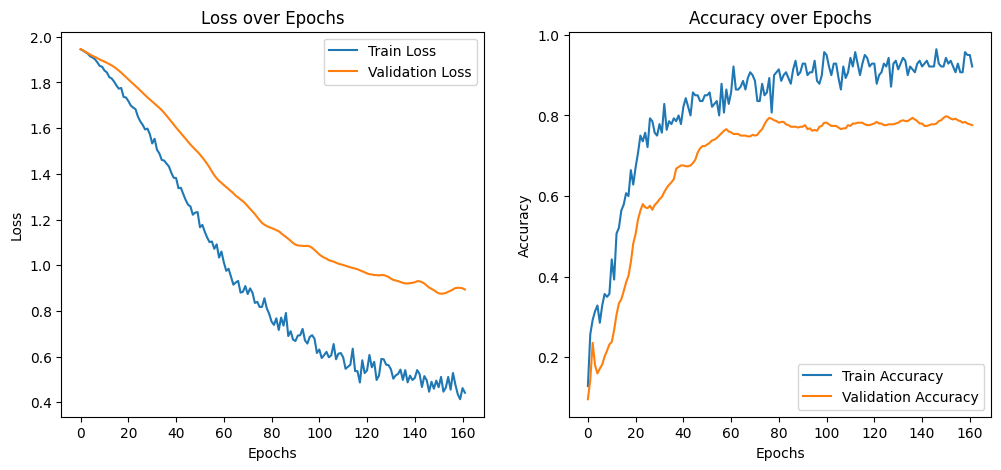

In [13]:
plot_history(history)